In [2]:
import os
os.getcwd()

'C:\\Users\\RENUKA\\Documents\\Task\\fake_news_detection\\notebooks'

In [3]:
os.listdir()

['.ipynb_checkpoints', 'fake_news_analysis.ipynb']

In [4]:
import pandas as pd

fake = pd.read_csv("../data/raw/Fake.csv")
true = pd.read_csv("../data/raw/True.csv")

print(fake.shape, true.shape)
print(fake.columns)

(23481, 4) (21417, 4)
Index(['title', 'text', 'subject', 'date'], dtype='object')


# Label, Merge & Inspect

## Add Labels

In [5]:
#label the data
fake["label"]=0 #fake news
true["label"]=1 #real news

## Merge Datasets

In [6]:
import pandas as pd
df=pd.concat([fake,true],axis=0)
df=df.sample(frac=1,random_state=42).reset_index(drop=True)

## Keeping only useful columns

In [7]:
df=df[["title","text","label"]]

## Quick Sanity Checks

In [8]:
df.head()

,title,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1


In [9]:
df.shape

(44898, 3)

In [10]:
df["label"].value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

## Checking for missing values

In [11]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [12]:
df.dropna(inplace=True)

# Text Preprocessing

## Combine title and text

In [13]:
df["content"]=df["title"]+" "+df["text"]

## Import NLP tools

In [14]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RENUKA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RENUKA\AppData\Roaming\nltk_data...


True

## Define cleaning function

In [15]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)      # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)     # remove punctuation & numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) 
              for word in tokens 
              if word not in stop_words]
    return " ".join(tokens)

## Apply cleaning

In [16]:
df["clean_content"]=df["content"].apply(clean_text)

### Inspection

In [17]:
df[["content","clean_content"]].head(3)

,content,clean_content
0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call th circuit court committed coup...
1,Trump drops Steve Bannon from National Securit...,trump drop steve bannon national security coun...
2,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u lift jones act shipping ...


# Feature Engineering

# TF-IDF Vectorisation & Data Split

## Importing required Libraries

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## Define TF-IDF Vectorizer

In [21]:
tfidf=TfidfVectorizer(max_features=5000, ngram_range=(1,2))

## Vectorize Text

In [22]:
X=tfidf.fit_transform(df["clean_content"])
y=df["label"]

In [23]:
X.shape

(44898, 5000)

## Train-test split

In [24]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [25]:
print(X_train.shape)
print(X_test.shape)

(35918, 5000)
(8980, 5000)


In [26]:
y_train.value_counts(normalize=True)

label
0    0.522997
1    0.477003
Name: proportion, dtype: float64

# Model Training

# Train ML Models

## Import models & metrics

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

## Train Logistic Regression

In [28]:
lr_model=LogisticRegression(max_iter=1000)
lr_model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

## Evaluate Logistic Regression

In [31]:
lr_preds=lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test,lr_preds))
print(classification_report(y_test,lr_preds))

Logistic Regression Accuracy: 0.9902004454342984
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



## Train Naive Bayes

In [33]:
nb_model=MultinomialNB()
nb_model.fit(X_train,y_train)

MultinomialNB()

## Evaluate Naive Bayes

In [36]:
nb_preds=nb_model.predict(X_test)
print("Naive Bayes Accuracy:",accuracy_score(y_test,nb_preds))
print(classification_report(y_test,nb_preds))

Naive Bayes Accuracy: 0.9466592427616927
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4696
           1       0.94      0.95      0.94      4284

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



# Explainability & Prediction

## Inspect important words

In [37]:
import numpy as np

feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Top words for REAL news (label = 1)
top_real = np.argsort(coefficients)[-15:]

# Top words for FAKE news (label = 0)
top_fake = np.argsort(coefficients)[:15]

print("Top REAL news words:")
print(feature_names[top_real])

print("\nTop FAKE news words:")
print(feature_names[top_fake])

Top REAL news words:
['said statement' 'dont' 'edt' 'nov' 'monday' 'friday' 'thursday'
 'reuters president' 'washington' 'tuesday' 'wednesday' 'president donald'
 'washington reuters' 'said' 'reuters']

Top FAKE news words:
['video' 'via' 'image' 'president trump' 'gop' 'hillary' 'obama' 'mr'
 'image via' 'even' 'american' 'breaking' 'america' 'wire' 'like']


## Build a prediction

In [39]:
def predict_news(text):
    cleaned = clean_text(text)
    vector = tfidf.transform([cleaned])
    prediction = lr_model.predict(vector)[0]
    
    if prediction == 1:
        return "REAL NEWS"
    else:
        return "FAKE NEWS"

## Test with custom input

In [40]:
sample_news = """
Scientists at NASA confirm discovery of water on Mars after years of research.
"""

print(predict_news(sample_news))

FAKE NEWS


In [41]:
fake_sample = """
Shocking truth the government doesn't want you to know about vaccines and mind control.
"""

print(predict_news(fake_sample))

FAKE NEWS


# Project Polishing & Final Touches

# Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

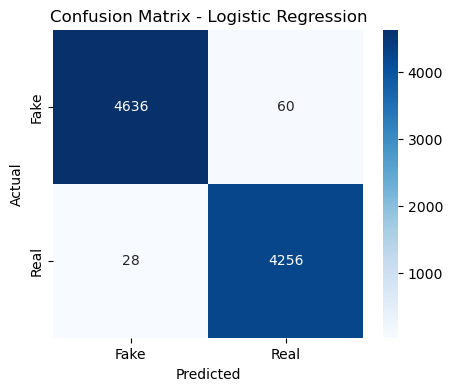

In [43]:
cm = confusion_matrix(y_test, lr_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fake", "Real"],
            yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Save model & Vectorizer

In [44]:
import joblib

joblib.dump(lr_model, "fake_news_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [45]:
model = joblib.load("fake_news_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

## Conclusion

This project implemented an end-to-end fake news detection system using NLP and machine learning.
The Logistic Regression model achieved high accuracy using TF-IDF features.
Limitations include reliance on linguistic patterns rather than factual verification.
Future work includes LLM-based fact verification and deployment as a web service.